#  Novel Time Series Primitive that Allows Real World Classification

## Contrast Profile

The tutorial is adapted from the [Matrix Profile XXIII paper](https://www.cs.ucr.edu/~eamonn/ContrastProfile_V048_names.pdf).  

Subsequence’s distance to its nearest neighbor within the same 
dataset can be represented by the [Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html).  

However, we argue that it may be useful to score subsequences with a new 
piece of meta-data that reflects the property that a subsequence 
is  simultaneously  close  to  its  nearest  neighbor  in  certain  data 
but far from its nearest neighbor in other **“black-listed”** data.  

We call this property **Contrast**, and the vector that represents it the 
**Contrast Profile**.  

While the proposed representation has many 
uses, for clarity, we will introduce it in the context of 
subsequence extraction to allow classification.


## Getting Started
Let's import the packages that we'll need to load, analyze, and plot the data.

In [1]:
import stumpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

## Loading the ECG data
Let's walk through by running example of a noisy electrocardiogram(ECG).  
From the dataset, we extract two snippet:v_pos[T(+)] and v_neg[T(-)]. Those are around 27-second snippet.  
Also specification of T(+), T(-) is followings.
- 𝐓(+): contains  **at  least  two  instances**  that  are  unique  to the phenomena of interest. 
- 𝐓(−): contains **zero instances of interest**.  

T(+) requires at least two instances. At this time, T(+) has two desired instances.

In [2]:
ecg_df = pd.read_csv("14172m.csv", index_col=0).astype(float) 
ecg_df.head()

,0,1
0,12.0,-12.0
1,10.0,-14.0
2,10.0,-12.0
3,14.0,-10.0
4,18.0,-4.0


In [3]:
v_pos = ecg_df.iloc[64630:68129, 1].values  # T(+)
v_neg = ecg_df.iloc[69880:73379, 1].values  # T(-)

m = 128
idx_desired0, idx_desired1 = 550, 2030

In [6]:
dfx = pd.DataFrame([v_neg, v_pos]).T
dfx.columns = ["T(-)", "T(+)"]
dfx.to_csv("ECG.csv")

## Visualizing the ECG snippets with desired behavabior.

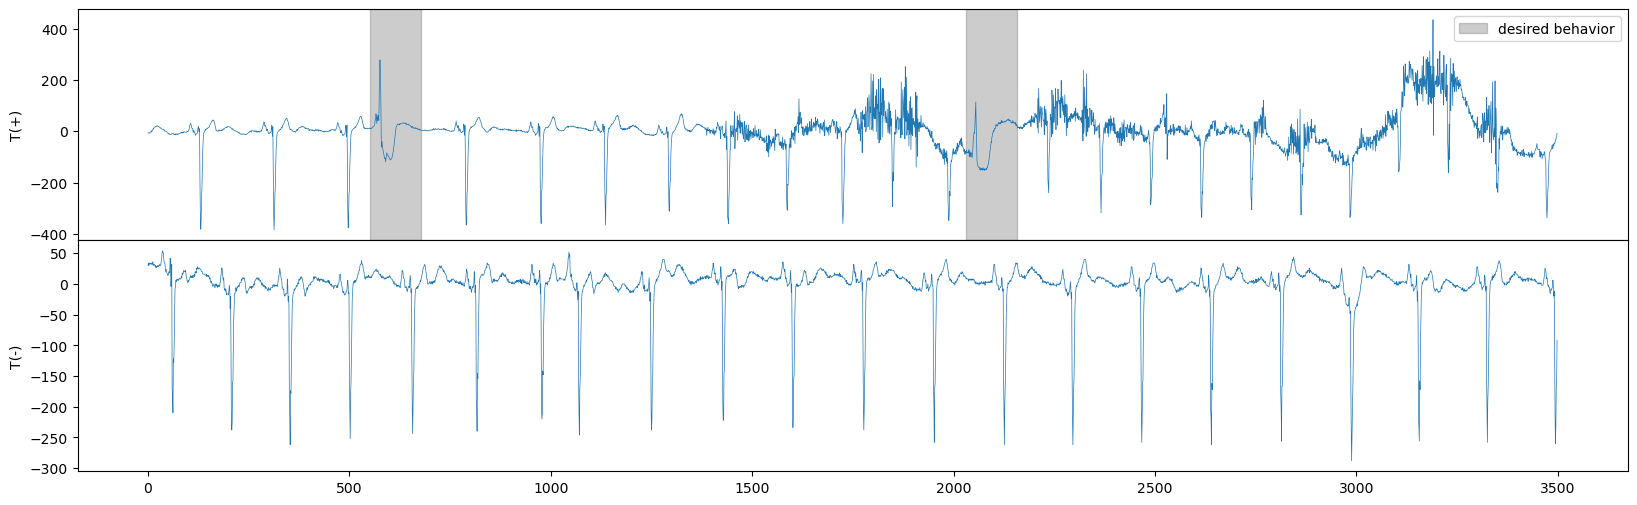

In [4]:
fig, axis = plt.subplots(2, 1, gridspec_kw={"hspace":0})
axis[0].plot(v_pos, linewidth=0.5)
axis[1].plot(v_neg, linewidth=0.5)
axis[0].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4, label="desired behavior")
axis[0].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)
axis[0].set_ylabel("T(+)")
axis[1].set_ylabel("T(-)")
axis[0].legend(loc=1)

plt.show()

[Upper fig] : T(+) looks noisy, 𝐓(+) have to include contains  **at  least  two  instances**. Signals on grey area are the "desired behaviors" which are similar.  

[Bottom fig] : T(-) looks clean, much more regular repeated pattern. Because T(-) has to be **zero instances of interest**.

## Couldn't find simply?
I'll show the result of applying distance profile, Matrix profile, and why Contrast profle is needed.
- 1.Distance Profile with normal beat query
- 2.self-join Matrix Profile
- 3.AB-join Matrix Profile

### 1.Distance Profile with normal beat query
Desired behavior is so different from normal ECG signal. So, desired behavior could be enough high value to find it in distance profile with normal ECG query and T(+).  
I pick up v_query(typcial normal ECG query) we can see everywhere in dataset.

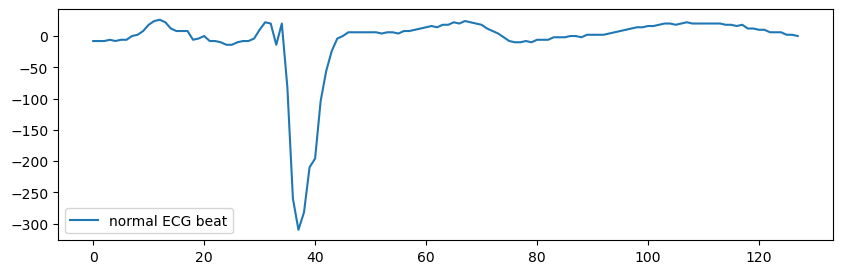

In [25]:
v_query = ecg_df.iloc[5930:5930+m, 1].values
plt.figure(figsize=(10,3))
plt.plot(v_query, label="normal ECG beat")
plt.legend()
plt.show()

In [22]:
# Distance Profile pos(include desired behavior)
DP_query = stumpy.mass(v_query, v_pos)
idx_motif = np.argmin(DP_query)

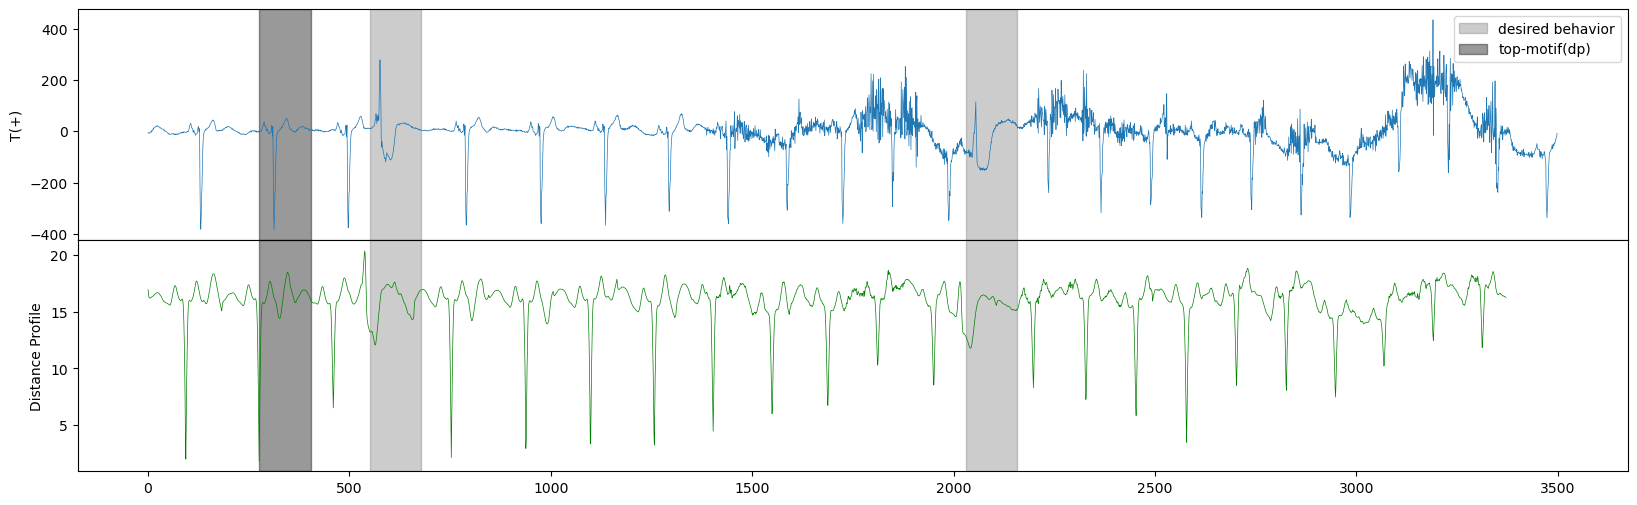

In [23]:
fig, axis = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0.0})
axis[0].plot(v_pos, linewidth=0.5)
axis[1].plot(DP_query, linewidth=0.5, color="green")
axis[0].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4, label="desired behavior")
axis[1].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4)
axis[0].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)
axis[1].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)
axis[0].axvspan(idx_motif, idx_motif+m, color="k", alpha=0.4, label="top-motif(dp)")
axis[1].axvspan(idx_motif, idx_motif+m, color="k", alpha=0.4)
axis[0].set_ylabel("T(+)")
axis[1].set_ylabel("Distance Profile")
axis[0].legend()
plt.show()

Even thought desired behavior subsequence is quite different compared to query.  
Distance profile on desierd behavior isn't enough to high to find those.  

### 2.self-join Matrix Profile

In [8]:
MP_AA = stumpy.stump(v_pos, m)
idx_motif = np.argmin(MP_AA[:, 0])
idx_nn = MP_AA[:, 1][idx_motif]

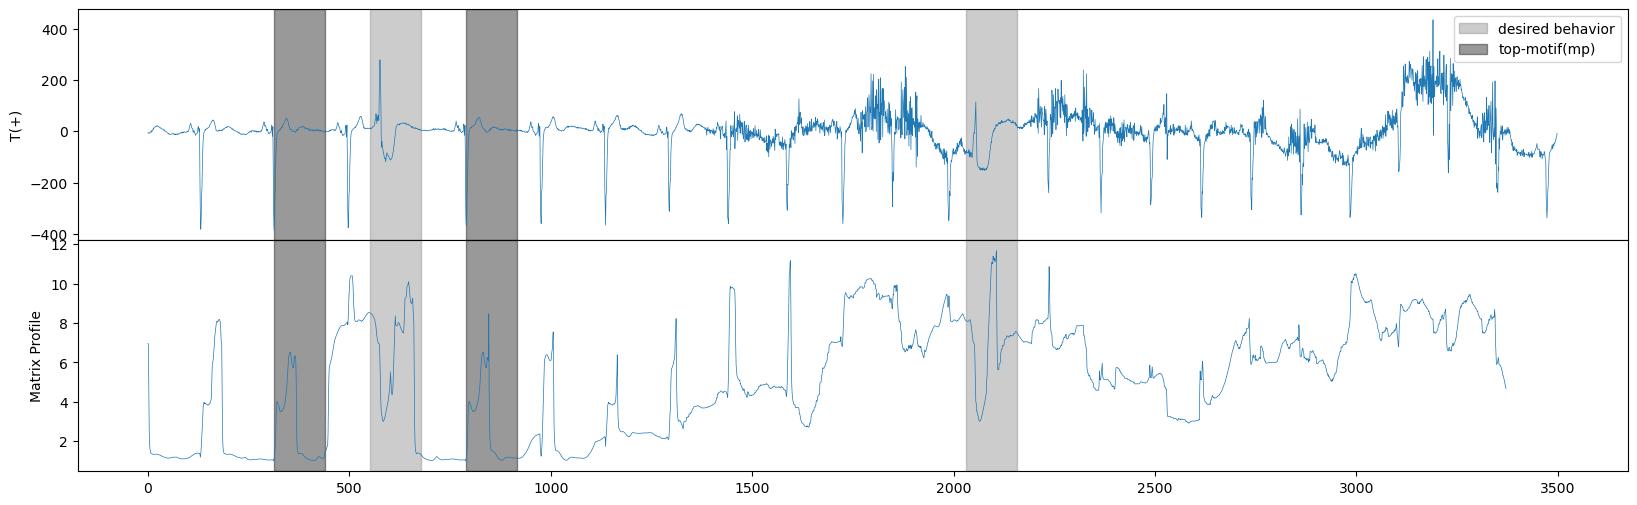

In [9]:
fig, axis = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0.0})
axis[0].plot(v_pos, linewidth=0.5)
axis[1].plot(MP_AA[:, 0], linewidth=0.5)
axis[0].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4, label="desired behavior")
axis[1].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4)
axis[0].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)
axis[1].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)
axis[0].axvspan(idx_motif, idx_motif+m, color="k", alpha=0.4, label="top-motif(mp)")
axis[1].axvspan(idx_motif, idx_motif+m, color="k", alpha=0.4)
axis[0].axvspan(idx_nn, idx_nn+m, color="k", alpha=0.4)
axis[1].axvspan(idx_nn, idx_nn+m, color="k", alpha=0.4)
axis[0].set_ylabel("T(+)")
axis[1].set_ylabel("Matrix Profile")
axis[0].legend(loc=1)
plt.show()

We annotated the location of two premature ventricular contractions (Desired behavior).  
While these **two beats are similar**, they are not as well conserved as normal beats.  
Matrix profile on desierd behavior also doesn't have no specific features for classification.

### 3.AB-join Matrix Profile
Insead of arbitrarily choosing normal ECG signal query, how about comparing T(+) has desired behavior with the clean T(-).

In [10]:
MP_AB = stumpy.stump(v_pos, m, v_neg, ignore_trivial = False)
idx_motif = np.argmin(MP_AB[:, 0])
idx_nn = MP_AB[:, 1][idx_motif]

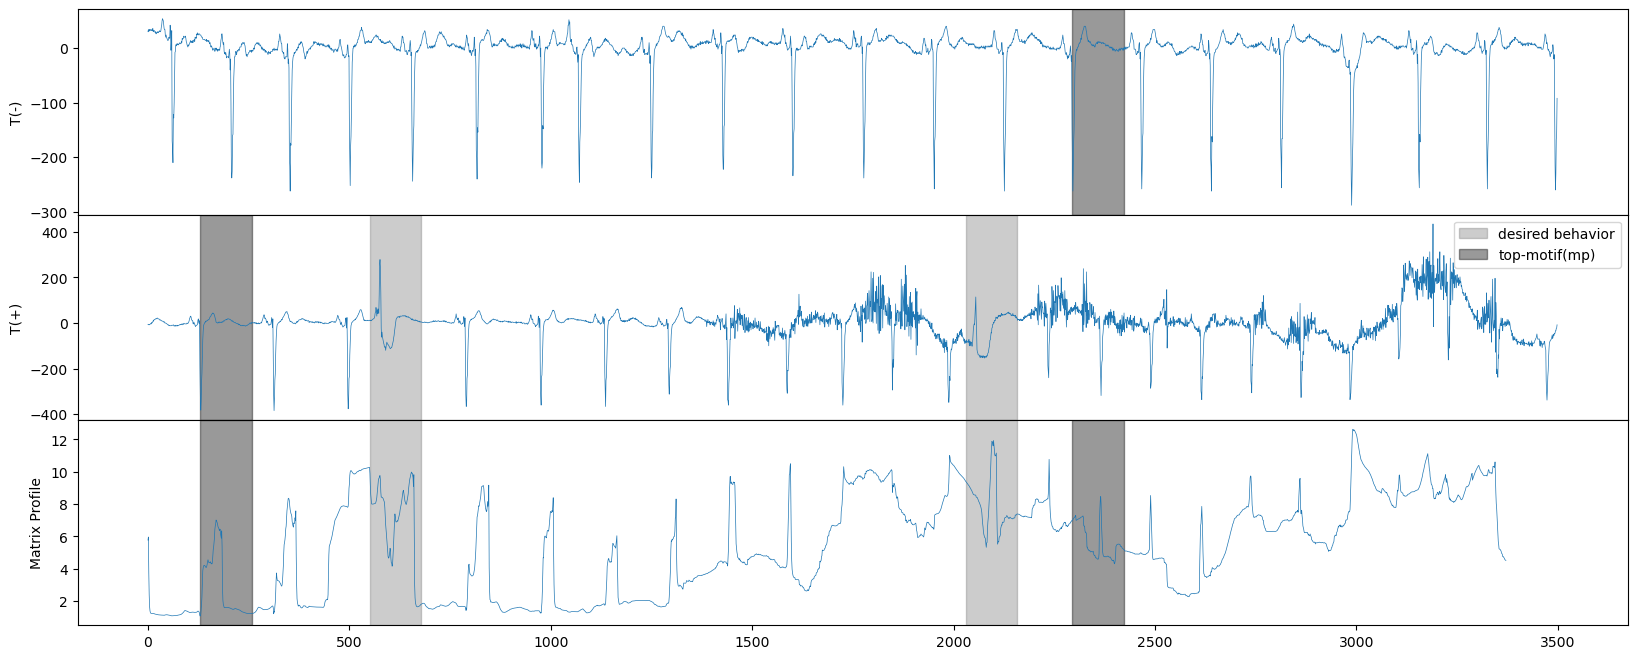

In [11]:
fig, axis = plt.subplots(3, 1, sharex=True, gridspec_kw={"hspace":0.0}, figsize=(20, 8))
axis[0].plot(v_neg, linewidth=0.5)
axis[1].plot(v_pos, linewidth=0.5)
axis[2].plot(MP_AB[:, 0], linewidth=0.5)

axis[1].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4, label="desired behavior")
axis[2].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4)
axis[1].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)
axis[2].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)
axis[1].axvspan(idx_motif, idx_motif+m, color="k", alpha=0.4, label="top-motif(mp)")
axis[2].axvspan(idx_motif, idx_motif+m, color="k", alpha=0.4)
axis[0].axvspan(idx_nn, idx_nn+m, color="k", alpha=0.4)
axis[2].axvspan(idx_nn, idx_nn+m, color="k", alpha=0.4)
axis[0].set_ylabel("T(-)")
axis[1].set_ylabel("T(+)")
axis[2].set_ylabel("Matrix Profile")
axis[1].legend(loc=1)
plt.show()

AB-join Matrix Profile is also almost same result to self-join Matrix Profile in most regions.  

We now exploit an important observation.  
This makes sense. A noisy $T_{i, m}^A$ will tend to be just as far from any other $T_{j, m}^A$ as it is  from  any  $T_{k, m}^B$.  
Moreover, a normal heartbeat 
in $T^A$ will tend to have approximately the same low distance 
to another normal heartbeat, whether that beat happens to come 
from $T^A$  or  $T^B$.  

The only places showing a significant difference are the locations corresponding to behaviors that are 
unique to $T^A$:in this case, the two PVC beats(desired behavior).

We formalize these observations with our proposed representation, the **Contrast Profile**.

$CP_m = (MP_{m}^{(+-)} - MP_{m}^{(++)}/ \sqrt{(2*m)}$    

- 𝐓(+): contains  at  least  two  behaviors  that  are  unique  to the phenomena of interest. 
- 𝐓(−): contains zero behaviors of interest.  
- Contrast Profile $CP_m$  
- Matrix Profiles $MP_{m}^{(+-)}$: Matrix profile joins T(+) with T(-)  
- Matrix Profiles $MP_{m}^{(++)}$: Matrix profile the self-join of 𝐓(+)  

## Contrast Profile
##### Plato
The subsequence in 𝐓(+) corresponding to the highest point in the Contrast Profile is called the **Plato**.  
A backronym of *pattern likely able to organize*, which is suggestive of a *platonic* ideal for some behavior of interest.

In [12]:
CP = (MP_AB[:, 0] - MP_AA[:, 0])/np.sqrt(2*m)
idx_plato = np.argmax(CP)
CP_ = CP.copy()  # for visualization
CP_[CP_<0] = 0

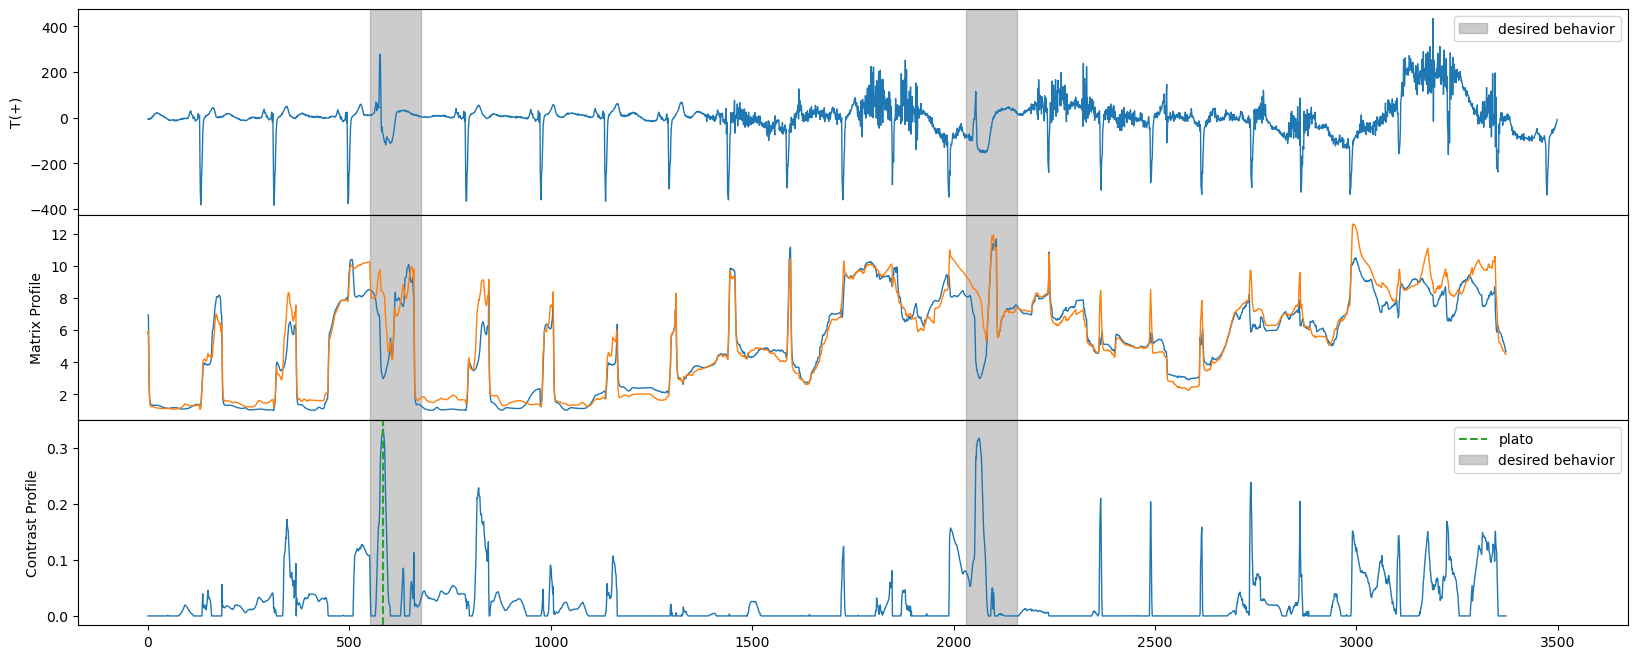

In [13]:
fig, axis = plt.subplots(3, 1, sharex=True, gridspec_kw={"hspace":0.0}, figsize=(20, 8))
axis[0].plot(v_pos, linewidth=1)
axis[1].plot(MP_AA[:, 0], linewidth=1, label="MP(++)")
axis[1].plot(MP_AB[:, 0], linewidth=1, label="MP(+-)")
axis[2].plot(CP_, linewidth=1)
axis[2].axvline(idx_plato, color="C2", linestyle="--", linewidth=1.5, label="plato")

axis[0].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4, label="desired behavior")
axis[1].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4)
axis[2].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4, label="desired behavior")
axis[0].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)
axis[1].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)
axis[2].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)

axis[0].set_ylabel("T(+)")
axis[1].set_ylabel("Matrix Profile")
axis[2].set_ylabel("Contrast Profile")
axis[0].legend()
axis[2].legend()
plt.show()

Now we can clealy find highest peak in desired behaviors.
### Let's find top-motif of plato in T(+)

In [14]:
# find top motif with plato
l_p = len(v_pos)
DP_plato = stumpy.mass(v_pos[idx_plato:idx_plato+m], v_pos)

# ignore trivial 
idx0 = idx_plato-m/2 if idx_plato-m/2 >= 0 else 0
idx1 = idx_plato+m/2 if idx_plato+m/2 <= l_p-m/2+1  else 0
idx0, idx1 = int(idx0), int(idx1)
x_ = np.arange(l_p)
x_t = np.hstack([x_[:idx0+1], x_[idx1:]])
DP_plato_t = np.hstack([DP_plato[:idx0+1], DP_plato[idx1:]])

idx_plato_twin = x_t[np.argmin(DP_plato_t)]

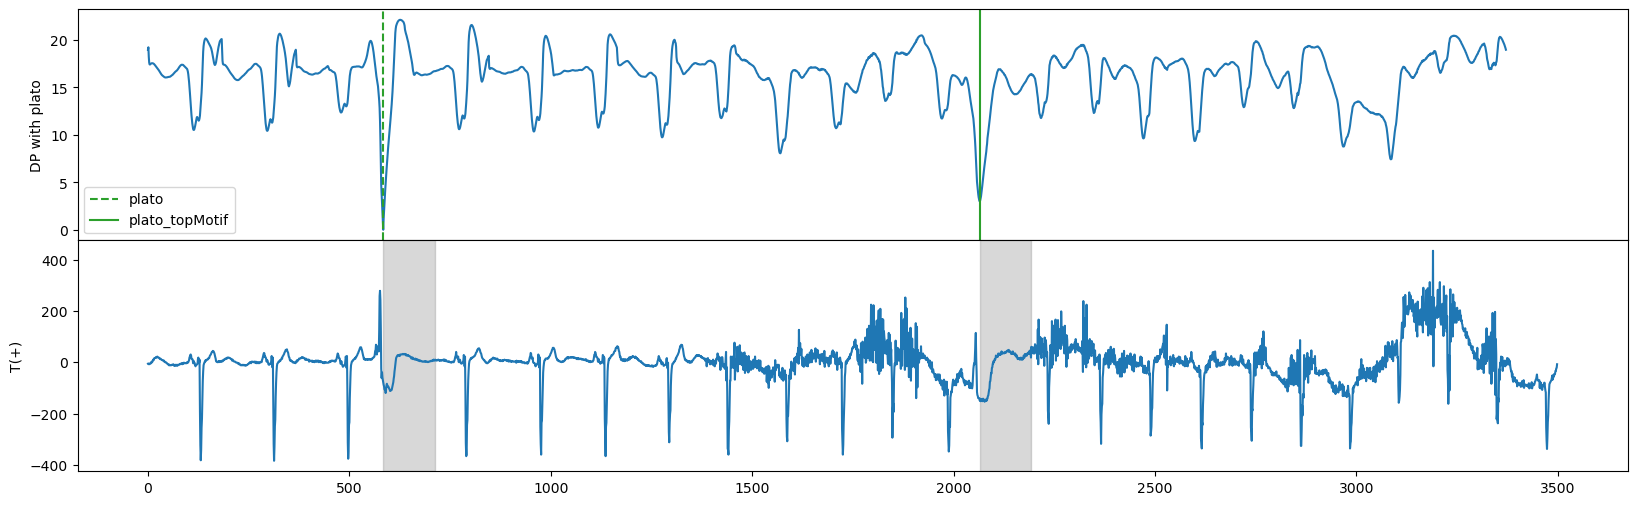

In [15]:
fig, axis = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0.0})
axis[0].plot(DP_plato)
axis[0].axvline(idx_plato, color="C2", linestyle="--", label="plato")
axis[0].axvline(idx_plato_twin, color="C2", label="plato_topMotif")
axis[0].set_ylabel("DP with plato")
axis[0].legend(loc=4)

axis[1].plot(v_pos)
axis[1].axvspan(idx_plato, idx_plato+m, color="grey", alpha=0.3, label="plato")
axis[1].axvspan(idx_plato_twin, idx_plato_twin+m, color="grey", alpha=0.3)
axis[1].set_ylabel("T(+)")
axis[0].legend()
plt.show()

### Comparing disired behavior and plato

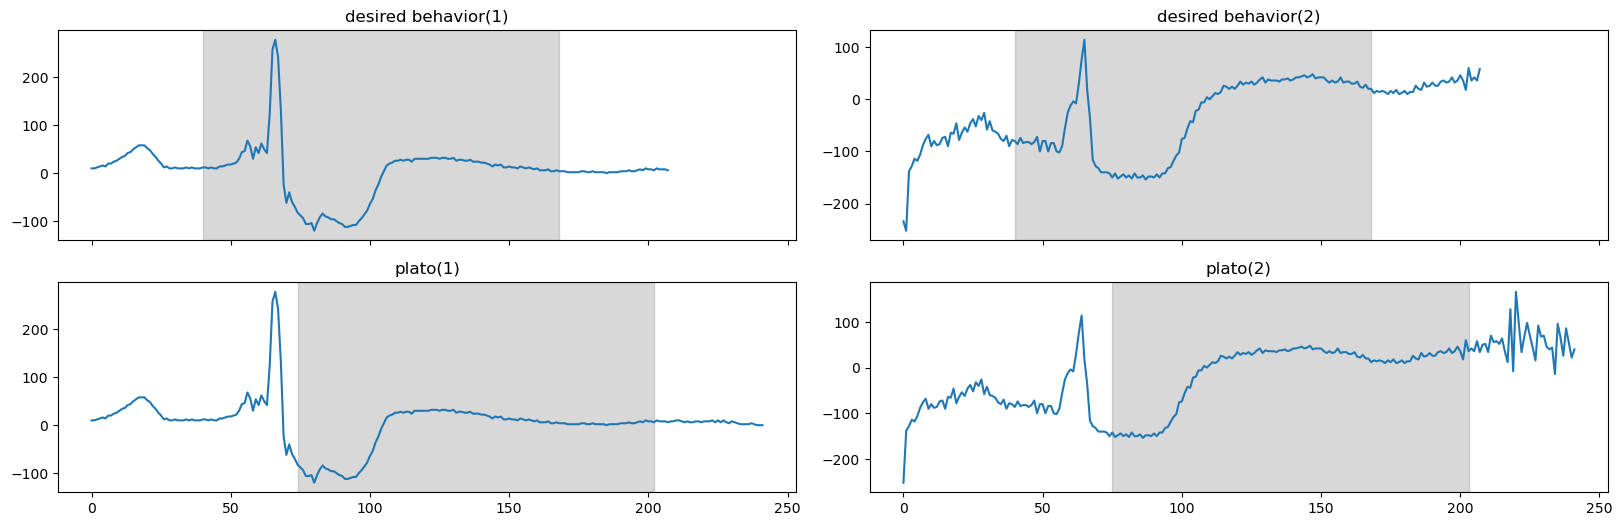

In [16]:
gap = 40
diff0 = idx_plato - idx_desired0
diff1 = idx_plato_twin - idx_desired1

fig, axis = plt.subplots(2, 2, sharex=True, gridspec_kw={"hspace":0.2, "wspace":0.1})
axis[0, 0].plot(v_pos[idx_desired0-gap:idx_desired0+m+gap])
axis[0, 1].plot(v_pos[idx_desired1-gap:idx_desired1+m+gap])
axis[1, 0].plot(v_pos[idx_plato-gap-diff0:idx_plato+m+gap])
axis[1, 1].plot(v_pos[idx_plato_twin-gap-diff0:idx_plato_twin+m+gap])

axis[0, 0].axvspan(gap, gap+m, color="grey", alpha=0.3, label="plato")
axis[0, 1].axvspan(gap, gap+m, color="grey", alpha=0.3)
axis[1, 0].axvspan(gap+diff0, gap+m+diff0, color="grey", alpha=0.3, label="plato")
axis[1, 1].axvspan(gap+diff1, gap+m+diff1, color="grey", alpha=0.3)

axis[0, 0].set_title("desired behavior(1)")
axis[1, 0].set_title("plato(1)")
axis[0, 1].set_title("desired behavior(2)")
axis[1, 1].set_title("plato(2)")

plt.show()

That's not exact match but we could find desired behavior(Plato) by Contrast Profile.

## Summary
We can find desired behavior by the subsequence in T(+) corresponding to the highest point in the Contrast Profile.  
While  we  use  the  Matrix  Profile  as  the  core  function  to 
compute  the  Contrast  Profile,  the  value  optimized  is  rather simple.

This clearly has implications for several  downstream  algorithms,  including  classification  and novelty/anomaly  detection. 

## Resources
[Matrix Profile XXIII](https://www.cs.ucr.edu/~eamonn/ContrastProfile_V048_names.pdf)  

[Contrast Profile support page](https://sites.google.com/view/contrastprofile)